# ML-13 Project. Part I

Ниже приведено решение первой части проекта по прогнозированию временных рядов. В практике приведены конкретные шаги, которые необходимо выполнить для получения требуемого результата. Эти шаги указаны ниже по пунктам, после каждого пункта идёт код для его реализации.

Также дополнительно приведены собственные исследования и выводы.

**Формулировка задачи:** Представьте, что вы работаете в государственной компании, предоставляющей анализ экономической ситуации в мире по заказу государства.

Перед вами стоит задача проанализировать ВВП африканской страны Гана. Для этого вам предоставили показатели ВВП Ганы за 62 года. Вам предстоит исследовать временной ряд, изучить его свойства, построить модели и сделать выводы по результатам.

In [24]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

import pmdarima as pm


In [49]:
from warnings import filterwarnings
filterwarnings("ignore")

## 1. Первоначальная загрузка и анализ данных

Прочитайте исходный файл с данными. Визуализируйте исходный временной ряд, сделайте первичные выводы о присутствии компонент тренда и сезонности в ряде.

Отложите последние три года из датасета как тестовую выборку для оценки результатов предсказания.

In [25]:
df = pd.read_csv('data/ghana_gdp.zip', index_col=['year'], parse_dates=['year'])
df.rename(columns={'GDP (current US$)':'gdp'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62 entries, 1960-01-01 to 2021-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   gdp     62 non-null     float64
dtypes: float64(1)
memory usage: 992.0 bytes


Text(0.5, 1.0, 'Распределение ВВП африканской страны Гана')

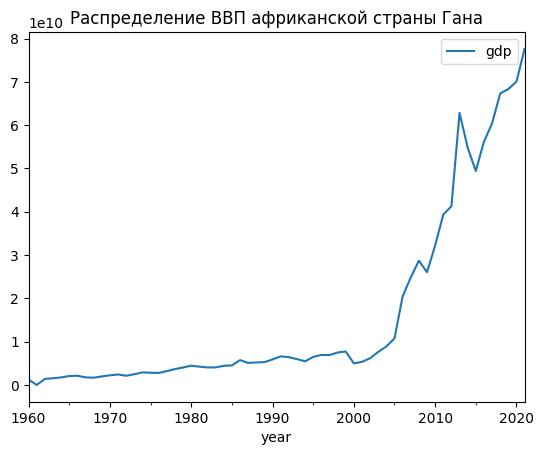

In [26]:
df.plot()
plt.title('Распределение ВВП африканской страны Гана')

**Первичные выводы:** на графике явно прослеживается общий тренд на увеличение. Причём до 2000 года повышение было малозаметным, после чего произошёл резкий скачок, провисший только в середине 10-х, во время мирового кризиса 14-15 года.

Сезонность на первый взгляд не видна.

Разложим ряд на тренд, сезонность и шум:

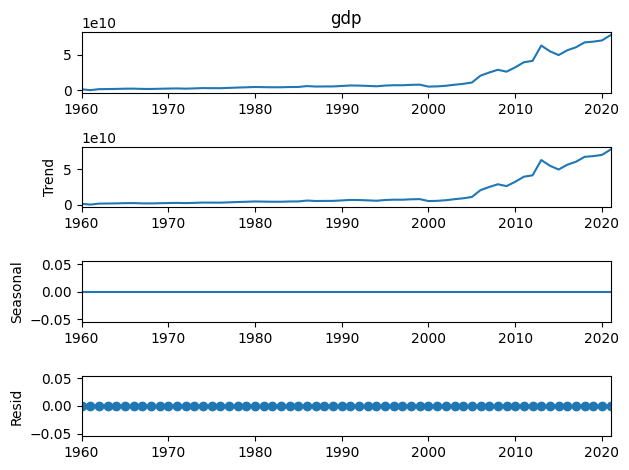

In [27]:
decompos = seasonal_decompose(df.gdp)
decompos.plot()
plt.show()

Как мы видим, наши первоначальные выводы оказались верны: тренд выделен, сезонности нет.

In [28]:
# разделяем выборку на тренировочную и тестовую
train_df = df.iloc[:-3]
test_df = df.iloc[-3:]
print(train_df.shape, test_df.shape)

(59, 1) (3, 1)


## 2. Построение модели скользящего среднего – MA

Постройте модель скользящего среднего, проанализируйте результат. Для построения MA используйте метод `rolling()`, который принимает в качестве параметра размер окна. Используйте среднее как функцию для сглаживания. Ширину окна подберите самостоятельно.

**Пример**: `train_df.spx.rolling(window=2).mean()`

Визуализируйте исходный временной ряд и построенный с помощью скользящего среднего прогноз, сравните графики между собой и сделайте выводы.

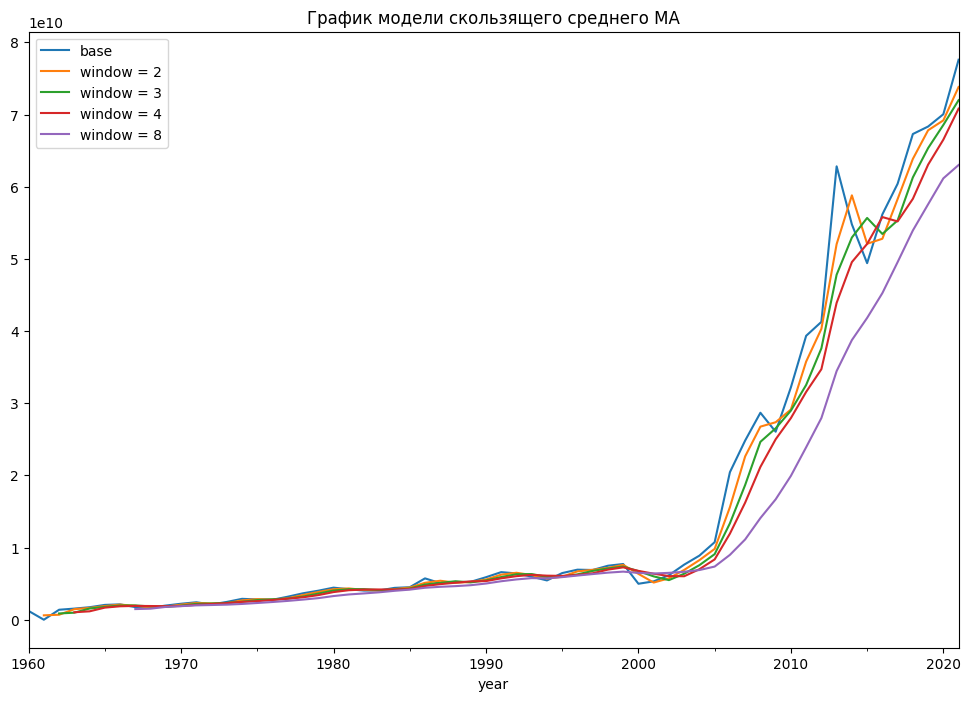

In [29]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()
df.plot(ax=ax)
df.gdp.rolling(window=2).mean().plot(ax=ax)
df.gdp.rolling(window=3).mean().plot(ax=ax)
df.gdp.rolling(window=4).mean().plot(ax=ax)
df.gdp.rolling(window=8).mean().plot(ax=ax)
ax.legend(['base', 'window = 2','window = 3', 'window = 4', 'window = 8'])
ax.set_title('График модели скользящего среднего MA')
plt.show()

**Выводы:** график скользящего среднего обычно используется для выявления и визуализации тренда. В нашем случае и распределение основного признака без преобразований отлично показывает тренд. Но график скользящего среднего с окном в 4-8 вполне дополняет наши первоначальные выводы.
Хотя окно более 4 уже скрывает просадки во время мировых финансовых кризисов. Поэтому в данном случае лучше использовать усреднение с окном не более 3.

## 3. Построение модели ARMA/ARIMA

С помощью теста Дики-Фуллера оцените стационарность временного ряда и примите решение о выборе модели `ARMA/ARIMA`.

> **Примечание:** Если ваш ряд является нестационарным, дифференцируйте его до тех пор, пока он не станет таковым. Количество дифференцирований, необходимых для сведения ряда к стационарному, будет вашим параметром d для модели ARIMA.

Параметры `p` и `q` выберите по коррелограммам `ACF` и `PACF`.

> **Примечание**: Помните, что параметры p и q для ARMA/ARIMA определяются из коррелограмм стационарного ряда. То есть, если ваш изначальный временной ряд не являлся стационарным, то коррелограммы строятся для разностей того порядка, которые являются стационарными.

Постройте модель `ARMA/ARIMA` для прогнозирования поведения временного ряда.

Также постройте несколько моделей с параметрами, ближайшими к найденным p и q, и сравните коэффициент `AIC` (или подберите наилучшие параметры с помощью пакета `pmdarima`, как в скринкасте).

Для начала определим функцию, которая позволит нам узнать, является ли ряд стационарным.

In [30]:
def stat_test(df):
    """Определить, является ли входящий временной ряд стационарным

    Args:
        df (DataFrame): Dataframe с временным рядом на проверку стационарности тестом Дики-Фуллера
    """
    test = sm.tsa.adfuller(df)
    print ('adf: ', test[0] )
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print ('есть единичные корни, ряд не стационарен')
    else:
        print ('единичных корней нет, ряд стационарен')

Проверим наш ряд:

In [31]:
stat_test(train_df)

adf:  0.6529066974885374
p-value:  0.9888496277665573
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
есть единичные корни, ряд не стационарен


Ряд не является стационарным, необходимо его продифференцировать.

adf:  -1.670248303832079
p-value:  0.4465029329713883
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
есть единичные корни, ряд не стационарен


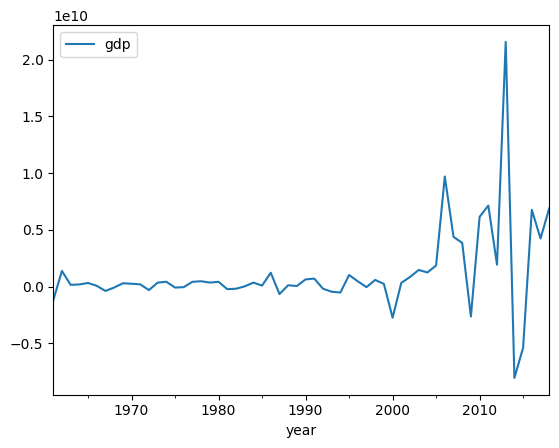

In [32]:
train_df_diff_1 = train_df.diff().dropna()
train_df_diff_1.plot()
stat_test(train_df_diff_1)

Ряд не стационарен, продолжаем дифферинцировать, пока не добьёмся стационарности:

adf:  -2.640869056128484
p-value:  0.08484116917837775
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
есть единичные корни, ряд не стационарен


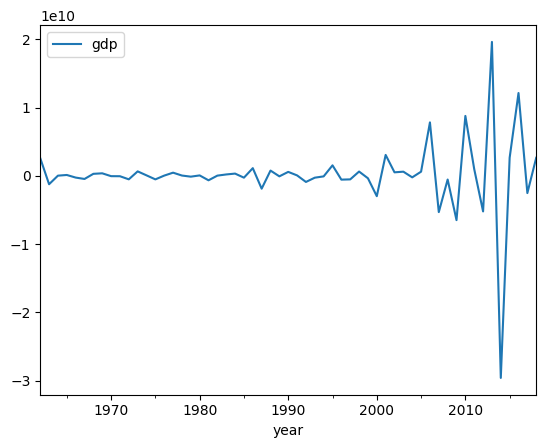

In [33]:
train_df_diff_2 = train_df_diff_1.diff().dropna()
train_df_diff_2.plot()
stat_test(train_df_diff_2)

adf:  -4.779623784828535
p-value:  5.9483276402248264e-05
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
единичных корней нет, ряд стационарен


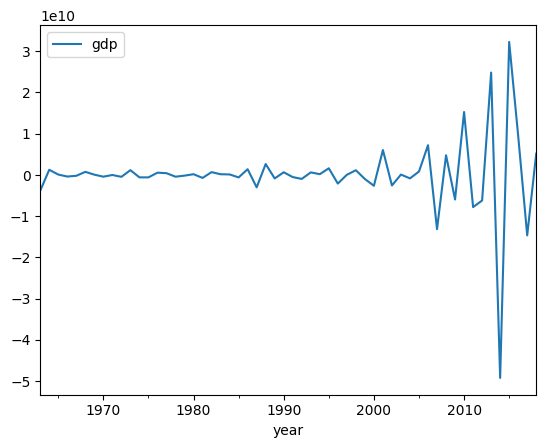

In [34]:
train_df_diff_3 = train_df_diff_2.diff().dropna()
train_df_diff_3.plot()
stat_test(train_df_diff_3)

**Вывод:** на третье дифференцирование ряд стал стационарным, то есть мы убрали из ряда тренд.

> **Примечение:** если бы порядок дифференцирования был выше, то вместо последовательных вызовов можно было бы написать функцию, которая в цикле или в рекурсии дифференцирует ряды, пока ряд не станет стационарным. Но для 3 порядка можно не тратить на это силы.

In [35]:
# запоминаем порядок дифференциала
d = 3

Определим параметры `p` и `q` по коррелограммам `ACF` и `PACF`

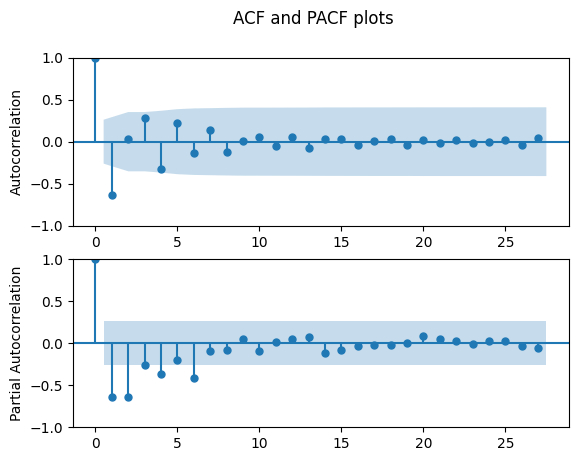

In [36]:
fig, (ax1, ax2) = plt.subplots(2, 1)
lags = 27
fig = sm.graphics.tsa.plot_acf(train_df_diff_3, lags=lags, ax=ax1)
ax1.set_ylabel('Autocorrelation')
ax1.set_title('')
# выбираем метод 'ywm', так как дефолтный метод 'yw' выводит коррелограмму за интервал [-1,1]
fig = sm.graphics.tsa.plot_pacf(train_df_diff_3, method='ywm', lags=lags, ax=ax2)
ax2.set_ylabel('Partial Autocorrelation')
ax2.set_title('')
fig.suptitle('ACF and PACF plots')
plt.show()

Определяем параметры:
* `p` — параметр авторегрессионной модели `(AR(p))`
* `q` — параметр скользящего среднего `(MA(q))`

In [37]:
p = 6
q = 2

Построим модель `ARIMA` для прогнозирования поведения временного ряда. Выбираем ARIMA, т.к. первоначальный ряд не стационарный и нам пришлось его дефферинцировать. 

In [38]:
arima_model = ARIMA(train_df_diff_3, order=(p, d, q)).fit()
arima_model.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary startin

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    gdp   No. Observations:                   56
Model:                 ARIMA(6, 3, 2)   Log Likelihood               -1275.381
Date:                Wed, 24 May 2023   AIC                           2568.763
Time:                        11:19:28   BIC                           2586.495
Sample:                    01-01-1963   HQIC                          2575.582
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8432        nan        nan        nan         nan         nan
ar.L2         -2.3961        nan        nan        nan         nan         nan
ar.L3         -2.2506        nan        nan        nan         nan         nan
ar.L4         -2.0067        nan        nan        nan         nan         nan
ar.L5         -1.3980        nan        nan        nan         nan         nan
ar.L6         -0.7819        nan        nan        nan         nan         nan
ma.L1         -1.8758        nan        nan        nan         nan         nan
ma.L2          0.9128        nan        nan        nan         nan         nan
sigma2      6.422e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   3.11   Jarque-Bera (JB):               170.74
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):              58.02   Skew:                            -1.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.53
===================================================================================

Warnings:
[1] Covariance matrix is singular or near-singular, with condition number    nan. Standard errors may be unstable.
"""

У построенной модели коэффициент `AIC = 2568.763`

Попробуем построить несколько моделей с параметрами, ближайшими к найденным p и q.

In [39]:
arima_model_test = ARIMA(train_df_diff_3, order=(p+2, d, q+2)).fit()
arima_model_test.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary startin

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    gdp   No. Observations:                   56
Model:                 ARIMA(8, 3, 4)   Log Likelihood               -1253.924
Date:                Wed, 24 May 2023   AIC                           2533.849
Time:                        11:19:28   BIC                           2559.463
Sample:                    01-01-1963   HQIC                          2543.699
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.4765        nan        nan        nan         nan         nan
ar.L2         -3.6003        nan        nan        nan         nan         nan
ar.L3         -4.0814        nan        nan        nan         nan         nan
ar.L4         -4.1425        nan        nan        nan         nan         nan
ar.L5         -3.5983        nan        nan        nan         nan         nan
ar.L6         -2.6734        nan        nan        nan         nan         nan
ar.L7         -1.2687        nan        nan        nan         nan         nan
ar.L8         -0.2724        nan        nan        nan         nan         nan
ma.L1         -1.9009        nan        nan        nan         nan         nan
ma.L2         -0.0193        nan        nan        nan         nan         nan
ma.L3          1.8891        nan        nan        nan         nan         nan
ma.L4         -0.9664        nan        nan        nan         nan         nan
sigma2        1.5e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                57.11
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):              20.15   Skew:                            -1.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.53
===================================================================================

Warnings:
[1] Covariance matrix is singular or near-singular, with condition number    nan. Standard errors may be unstable.
"""

Чуть-чуть поигравшись с параметрами, получили снижение `AIC` с `2568.763` до `2533.849`.

Теперь воспользуемся библиотекой `pmdarima` для подбора оптимальных гиперпараметров модели.

In [40]:
smodel = pm.auto_arima(
    train_df_diff_3,
    d=d,
    start_p=1,
    start_q=1,
    max_p=10,
    max_q=10,
    seasonal=False,
    error_action="ignore",
    trace=True,
    n_jobs= -1
)

smodel.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2783.875, Time=0.00 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2738.092, Time=0.01 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2725.278, Time=0.02 sec
 ARIMA(0,3,2)(0,0,0)[0]             : AIC=2724.689, Time=0.02 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=2689.333, Time=0.02 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=2641.473, Time=0.09 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2633.335, Time=0.03 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2625.096, Time=0.07 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(4,3,1)(0,0,0)[0]             : AIC=2598.119, Time=0.09 sec
 ARIMA(4,3,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(5,3,1)(0,0,0)[0]             : AIC=2600.285, Time=0.07 sec
 ARIMA(4,3,2)(0,0,0)[0]             : AIC=2577.063, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   56
Model:               SARIMAX(4, 3, 2)   Log Likelihood               -1281.532
Date:                Wed, 24 May 2023   AIC                           2577.063
Time:                        11:19:30   BIC                           2590.855
Sample:                    01-01-1963   HQIC                          2582.367
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7655        nan        nan        nan         nan         nan
ar.L2         -2.0299        nan        nan        nan         nan         nan
ar.L3         -1.4882        nan        nan        nan         nan         nan
ar.L4         -0.7523        nan        nan        nan         nan         nan
ma.L1         -1.9418        nan        nan        nan         nan         nan
ma.L2          0.9599        nan        nan        nan         nan         nan
sigma2      6.422e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):               458.90
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):             119.83   Skew:                            -2.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.84
===================================================================================

Warnings:
[1] Covariance matrix is singular or near-singular, with condition number    nan. Standard errors may be unstable.
"""

Попробуем построить модель с предложенными параметрами

In [79]:
arima_model_pm = ARIMA(train_df_diff_3, order=(4, d, 2)).fit()
arima_model_pm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    gdp   No. Observations:                   56
Model:                 ARIMA(4, 3, 2)   Log Likelihood               -1281.532
Date:                Wed, 24 May 2023   AIC                           2577.063
Time:                        14:55:09   BIC                           2590.855
Sample:                    01-01-1963   HQIC                          2582.367
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7655        nan        nan        nan         nan         nan
ar.L2         -2.0299        nan        nan        nan         nan         nan
ar.L3         -1.4882        nan        nan        nan         nan         nan
ar.L4         -0.7523        nan        nan        nan         nan         nan
ma.L1         -1.9418        nan        nan        nan         nan         nan
ma.L2          0.9599        nan        nan        nan         nan         nan
sigma2      6.422e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):               458.90
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):             119.83   Skew:                            -2.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.84
===================================================================================

Warnings:
[1] Covariance matrix is singular or near-singular, with condition number    nan. Standard errors may be unstable.
"""

**Выводы:** В итоге видим, что библиотека `pmdarima` выдала результаты хуже, чем ручной подбор параметров. Возможно я что-то не так настроил, но пока никак не могу заставить библиотеку просчитать все параметры, а не останавливаться на середине.

Главный вывод: на библиотеки надейся, но сам всё перепроверяй!

Раз не получилось воспользоваться библиотекой, то организуем подбор параметров самостоятельно.

In [80]:
p_test_strange, q_test_strange = 0, 0
aic_test_strange = 99999.00
result_model_strange = None

for i in range(11):
    for j in range(11):
        arima_model_test = ARIMA(train_df_diff_3, order=(i, d, j)).fit()
        # print(f'({i}, {d}, {j}). AIC = {arima_model_test.aic}')
        if arima_model_test.aic < aic_test_strange:
            aic_test_strange = arima_model_test.aic
            p_test_strange = i
            q_test_strange = j
            result_model_strange = arima_model_test

print(p_test_strange, q_test_strange, aic_test_strange)

7 0 16.0


In [81]:
result_model_strange.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    gdp   No. Observations:                   56
Model:                 ARIMA(7, 3, 0)   Log Likelihood                   0.000
Date:                Wed, 24 May 2023   AIC                             16.000
Time:                        14:55:30   BIC                             31.762
Sample:                    01-01-1963   HQIC                            22.061
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -4.2423        nan        nan        nan         nan         nan
ar.L2         -8.8155        nan        nan        nan         nan         nan
ar.L3        -12.1202        nan        nan        nan         nan         nan
ar.L4        -12.1127        nan        nan        nan         nan         nan
ar.L5         -8.7943        nan        nan        nan         nan         nan
ar.L6         -4.2215        nan        nan        nan         nan         nan
ar.L7         -0.9930        nan        nan        nan         nan         nan
sigma2      5.248e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                    nan   Jarque-Bera (JB):                  nan
Prob(Q):                               nan   Prob(JB):                          nan
Heteroskedasticity (H):                nan   Skew:                              nan
Prob(H) (two-sided):                   nan   Kurtosis:                          nan
===================================================================================

Warnings:
[1] Covariance matrix is singular or near-singular, with condition number    nan. Standard errors may be unstable.
"""

Получившиеся значения довольно странные. В итоговой проверке оказалось два набора гиперпараметров с очень низкой результирующей метрикой. 

Запомних эти гиперпараметры, но попробуем откинуть эти значения и поискать другой набор гиперпараметров, с более реалистичной метрикой.

In [82]:
p_test, q_test = 0, 0
aic_test = 99999.00
result_model = None

for i in range(11):
    for j in range(11):
        arima_model_test = ARIMA(train_df_diff_3, order=(i, d, j)).fit()
        # print(f'({i}, {d}, {j}). AIC = {arima_model_test.aic}')
        if 50 < arima_model_test.aic < aic_test:
            aic_test = arima_model_test.aic
            p_test = i
            q_test = j
            result_model = arima_model_test

print(p_test, q_test, aic_test)

8 4 2533.8488176253545


Смотрим на результаты получившейся модели:

In [83]:
result_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    gdp   No. Observations:                   56
Model:                 ARIMA(8, 3, 4)   Log Likelihood               -1253.924
Date:                Wed, 24 May 2023   AIC                           2533.849
Time:                        14:55:56   BIC                           2559.463
Sample:                    01-01-1963   HQIC                          2543.699
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.4765        nan        nan        nan         nan         nan
ar.L2         -3.6003        nan        nan        nan         nan         nan
ar.L3         -4.0814        nan        nan        nan         nan         nan
ar.L4         -4.1425        nan        nan        nan         nan         nan
ar.L5         -3.5983        nan        nan        nan         nan         nan
ar.L6         -2.6734        nan        nan        nan         nan         nan
ar.L7         -1.2687        nan        nan        nan         nan         nan
ar.L8         -0.2724        nan        nan        nan         nan         nan
ma.L1         -1.9009        nan        nan        nan         nan         nan
ma.L2         -0.0193        nan        nan        nan         nan         nan
ma.L3          1.8891        nan        nan        nan         nan         nan
ma.L4         -0.9664        nan        nan        nan         nan         nan
sigma2        1.5e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                57.11
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):              20.15   Skew:                            -1.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.53
===================================================================================

Warnings:
[1] Covariance matrix is singular or near-singular, with condition number    nan. Standard errors may be unstable.
"""

Итого у нас получилось две модели, со странной метрикой и с нормальной:
* `result_model_strange`
* `result_model`

Построим предсказание на каждой из них и сравним с тестовой выборкой.

In [84]:
result_model.predict(start=test_df.index[0], end=test_df.index[-1])

2019-01-01   -1.959916e+10
2020-01-01    2.685033e+10
2021-01-01   -3.140508e+10
Freq: AS-JAN, Name: predicted_mean, dtype: float64

In [104]:
result_model.get_forecast(len(test_df.index)).conf_int(alpha=0.05)

,lower gdp,upper gdp
2019-01-01,-2.735806e+10,-1.184025e+10
2020-01-01,1.373831e+10,3.996235e+10
2021-01-01,-4.454144e+10,-1.826872e+10


In [117]:

result_model_strange.get_forecast(len(test_df.index)).conf_int(alpha=0.05)

,lower gdp,upper gdp
2019-01-01,NaN,NaN
2020-01-01,NaN,NaN
2021-01-01,NaN,NaN


In [118]:
result_model_strange.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    gdp   No. Observations:                   56
Model:                 ARIMA(7, 3, 0)   Log Likelihood                   0.000
Date:                Wed, 24 May 2023   AIC                             16.000
Time:                        15:25:13   BIC                             31.762
Sample:                    01-01-1963   HQIC                            22.061
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -4.2423        nan        nan        nan         nan         nan
ar.L2         -8.8155        nan        nan        nan         nan         nan
ar.L3        -12.1202        nan        nan        nan         nan         nan
ar.L4        -12.1127        nan        nan        nan         nan         nan
ar.L5         -8.7943        nan        nan        nan         nan         nan
ar.L6         -4.2215        nan        nan        nan         nan         nan
ar.L7         -0.9930        nan        nan        nan         nan         nan
sigma2      5.248e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                    nan   Jarque-Bera (JB):                  nan
Prob(Q):                               nan   Prob(JB):                          nan
Heteroskedasticity (H):                nan   Skew:                              nan
Prob(H) (two-sided):                   nan   Kurtosis:                          nan
===================================================================================

Warnings:
[1] Covariance matrix is singular or near-singular, with condition number    nan. Standard errors may be unstable.
"""

In [111]:
test_model = ARIMA(train_df_diff_2, order=(7, 2, 0)).fit()
test_model.get_forecast(len(test_df.index)).conf_int(alpha=0.05)

,lower gdp,upper gdp
2019-01-01,-1.947075e+10,-5.595139e+09
2020-01-01,1.426804e+09,1.548234e+10
2021-01-01,-2.312524e+10,-8.677377e+09


Подготовим DataFrame с исходными и предсказанными данными:

In [131]:
pred_df = pd.DataFrame(index=df.index)
pred_df['gdp'] = df['gdp']

pred_df['model_preds'] = result_model.predict(
    start=test_df.index[0], end=test_df.index[-1]
)
pred_df['model_strange_preds'] = result_model_strange.predict(
    start=test_df.index[0], end=test_df.index[-1]
)

forecast_df = result_model.get_forecast(len(test_df.index)).conf_int(alpha=0.05)
pred_df.at[test_df.index, 'model_pred_lower'] = forecast_df['lower gdp']
pred_df.at[test_df.index, 'model_pred_upper'] = forecast_df['upper gdp']

# forecast_strange_df = result_model_strange.get_forecast(len(test_df.index)).conf_int(alpha=0.05)
# pred_df.at[test_df.index, 'model_strange_pred_lower'] = forecast_strange_df['lower gdp']
# pred_df.at[test_df.index, 'model_strange_pred_upper'] = forecast_strange_df['upper gdp']

pred_df.tail()

,gdp,model_preds,model_strange_preds,model_pred_lower,model_pred_upper
year,,,,,
2017-01-01,6.040638e+10,NaN,NaN,NaN,NaN
2018-01-01,6.729928e+10,NaN,NaN,NaN,NaN
2019-01-01,6.833754e+10,-1.959916e+10,6.047340e+11,-2.735806e+10,-1.184025e+10
2020-01-01,7.004320e+10,2.685033e+10,6.190524e+11,1.373831e+10,3.996235e+10
2021-01-01,7.759428e+10,-3.140508e+10,6.499556e+11,-4.454144e+10,-1.826872e+10


Построим графики:

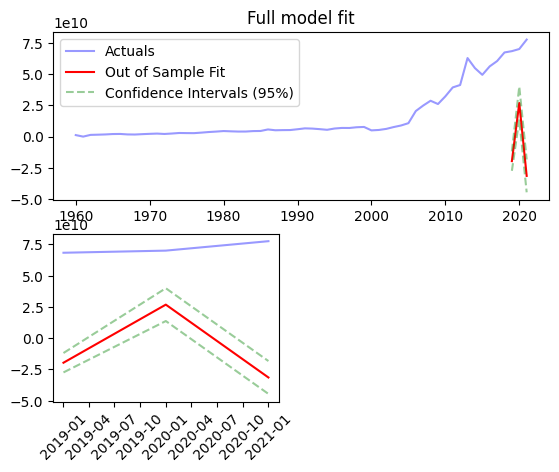

In [147]:
# график со всем рядом
plt.subplot(211)
plt.plot(pred_df['gdp'], color='blue', label='Actuals', alpha=.4)
plt.plot(pred_df.loc[test_df.index]['model_preds'], color='red', linestyle='-', label='Out of Sample Fit')
# plt.plot(pred_df.loc[test_df.index]['model_strange_preds'], color='orange', linestyle='-', label='Strange')
plt.plot(pred_df.loc[test_df.index]['model_pred_lower'], color='green', linestyle='--', label='Confidence Intervals (95%)', alpha=.4)
plt.plot(pred_df.loc[test_df.index]['model_pred_upper'], color='green', linestyle='--', alpha=.4)
plt.title('Full model fit')
plt.legend()

# график с приближением предсказанных значений
plt.subplot(223)
plt.plot(pred_df.loc[test_df.index]['gdp'], color='blue', label='Actuals', alpha=.4)
plt.plot(pred_df.loc[test_df.index]['model_preds'], color='red', linestyle='-', label='Out of Sample Fit')
plt.plot(pred_df.loc[test_df.index]['model_pred_lower'], color='green', linestyle='--', label='Confidence Intervals (95%)', alpha=.4)
plt.plot(pred_df.loc[test_df.index]['model_pred_upper'], color='green', linestyle='--', alpha=.4)
plt.xticks(rotation=45)

plt.show()
